In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from tqdm.auto import trange, tqdm
import os
import math
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM, GRU, SimpleRNN, BatchNormalization
from keras.models import Sequential, load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.optimizers import SGD,Adam
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import backend as K
from keras.losses import MeanSquaredLogarithmicError
from keras import Input

Using TensorFlow backend.


In [2]:
def plotTrainFigure(model, train_generator, dataframe, sc2, time_step=6, country='China'):
    # Confirmed cases
    pre_confirmed = []
    truth_confirmed = []
    # Fatalities
    pre_fatalities = []
    truth_fatalities = []
    for i in range(len(train_generator)):
        testx, testy = train_generator[i]
        
        pre = model.predict(testx)
        
        confirmed_pre = pre[0][0]
        confirmed_truth = testy[0][0]
        fatalities_pre = pre[0][1]
        fatalities_truth = testy[0][1]
        
        # The following is valid when the sc2 is 0-1 Scaler
#         t1 = confirmed_pre*dataframe.values[:,0].max()
#         t2 = confirmed_truth*dataframe.values[:,0].max()
#         t3 = fatalities_pre*dataframe.values[:,1].max()
#         t4 = fatalities_truth*dataframe.values[:,1].max()
        
        t1, t3 = tuple(sc2.inverse_transform([[confirmed_pre,fatalities_pre]])[0])
        t2, t4 = tuple(sc2.inverse_transform([[confirmed_truth,fatalities_truth]])[0])
        
#         t1, t3 = tuple([confirmed_pre,fatalities_pre])
#         t2, t4 = tuple([confirmed_truth,fatalities_truth])
        
        pre_confirmed.append(t1)
        truth_confirmed.append(t2)
        pre_fatalities.append(t3)
        truth_fatalities.append(t4)
    date = dataframe[time_step:int(len(data) * split)].index.values
#     date = dataframe[int(len(data) * split):-6].index.values

    print(len(date), len(pre_confirmed), len(truth_confirmed))
    Confirmed = pd.DataFrame({'Date':date,'Prediction':pre_confirmed,'Real cases':truth_confirmed})
    Confirmed.set_index(['Date'], inplace=True)
    
    Fatalities = pd.DataFrame({'Date':date,'Prediction':pre_fatalities,'Real cases':truth_fatalities})
    Fatalities.set_index(['Date'], inplace=True)
    
    Confirmed['Prediction'] = Confirmed['Prediction'].astype(int)
    Confirmed['Real cases'] = Confirmed['Real cases'].astype(int)
    Fatalities['Prediction'] = Fatalities['Prediction'].astype(int)
    Fatalities['Real cases'] = Fatalities['Real cases'].astype(int)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(17,7))
    Confirmed.plot(ax=ax1)
    ax1.set_title(country+" confirmed cases ", size=13)
    ax1.set_ylabel("Number of cases", size=13)
    ax1.set_xlabel("Date", size=13)
    
    Fatalities.plot(ax=ax2)
    ax2.set_title(country+" Fatalities ", size=13)
    ax2.set_ylabel("Number of cases", size=13)
    ax2.set_xlabel("Date", size=13)
    
    return Confirmed.copy(), Fatalities.copy()

In [4]:
def datelist(beginDate, endDate):
    # beginDate, endDate are something like ‘20160601’
    date_l=[datetime.strftime(x,'%Y-%m-%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
    return date_l

In [5]:
def printFigure(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [30]:
def MaxMinNormalization(data, feature_range=(0,1), split=0.8):
    sc = MinMaxScaler(feature_range=feature_range)
    scaled_data = sc.fit_transform(data.reshape(-1, 1)) if len(data.shape)==1 else sc.fit_transform(data)
#     scaled_data = data
    scaled_train = scaled_data[:int(len(scaled_data) * split)]
    scaled_val = scaled_data[int(len(scaled_data) * split):]
    return scaled_train, scaled_val, sc

In [48]:
def MaxMinNormalization2(data):
    sc = MinMaxScaler()
    scaled_data = sc.fit_transform(data.reshape(-1, 1)) if len(data.shape)==1 else sc.fit_transform(data)
    return scaled_data, sc

## Import data

In [7]:
rootPath = 'D:/Dropbox/Project/code/Python/COVID19-Global-Forecasting/data/'
trainFileName = 'train.csv'
testFileName = 'test.csv'
trainWithFlightFileName = 'train_flight.csv'

### Load file

In [8]:
def loadDataByCountry(Country = 'China', data_all=None, dateRange= ('2020-01-22','2020-04-13'), is_startFromFirstCaseDay=False):
    confirmed_total_date = data_all[data_all['Country_Region']==Country].groupby(['Date']).agg({'ConfirmedCases':['sum']})
    flight_total_date = data_all[data_all['Country_Region']==Country].groupby(['Date']).agg({'DepartureFlight':['mean']})
    data = data_all[data_all['Country_Region']==Country].groupby(['Date']).agg({'ConfirmedCases':['sum'],'Fatalities':['sum'],'DepartureFlight':['mean']})
    day = flight_total_date.shape[0]
    for i in tqdm(range(day), desc='Complete zero-value in flight data'):
        if flight_total_date.iloc[i].values[0]==0:
            flight_total_date.iloc[i] = int((flight_total_date.iloc[i-1]+flight_total_date.iloc[i+1])/2)
    
    is_FirstCase = False
    FirstCaseDate = dateRange[0]
    for i in tqdm(range(day), desc='Complete zero-value in data'):
        Date = data.iloc[i].name
        if not is_FirstCase:
            if data.iloc[i].values[1]!=0:
                print('For ', country, 'The first case during the period just has been found', Date)
                FirstCaseDate = Date
                is_FirstCase = True
            
        if data.iloc[i].values[2]==0:
            data.loc[Date,'DepartureFlight'] = int((data.iloc[i-1]['DepartureFlight']+data.iloc[i+1]['DepartureFlight'])/2)
    if not is_startFromFirstCaseDay:   
        return data.loc[dateRange[0]: dateRange[1]]
    else:
        return data.loc[FirstCaseDate: dateRange[1]]


In [9]:
# 

## LSTM model

In [10]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred) - K.log(y_true)), axis=-1)) 

In [11]:
# def simpleLSTM(time_step=6, nfeatures=3):
#     model = Sequential()
#     model.add(GRU(512, activation="tanh", input_shape=(time_step, nfeatures), return_sequences=True))
#     model.add(Dropout(0.25))
# #     model.add(LSTM(256, activation="tanh", return_sequences=True))
#     model.add(GRU(64, activation="tanh", return_sequences=False))
#     model.add(Dropout(0.25))
#     model.add(Dense(2, activation='linear'))
    
#     model.compile(loss=MeanSquaredLogarithmicError(), optimizer='adam')
#     model.summary()
#     return model

In [44]:
def aLSTM(time_step = 6, nfeatures=3):
    inputs = Input(shape=(time_step,nfeatures))
    lstm1 = LSTM(128, return_sequences = True, recurrent_dropout=0.5)(inputs)
    
    # Confiromed cases
    lstmC = LSTM(64)(lstm1)
    denseC1 = Dense(32, activation='relu')(lstmC)
    dropC1 = Dropout(0.5)(denseC1)
    denseC2 = Dense(2, activation='relu')(dropC1)
    
    # Fatalities
#     lstmF = LSTM(32)(lstm1)
#     denseF1 = Dense(128)(lstmF)
#     dropF1 = Dropout(0.5)(denseF1)
#     denseF2 = Dense(1, activation='relu')(dropF1)
    
    model = Model(inputs=inputs, outputs=denseC2)
#     
    model.compile(loss=MeanSquaredLogarithmicError(), optimizer='adam', metrics = ['accuracy'])
    model.summary()
    return model
    

## Training 

In [13]:
data_test = pd.read_csv(rootPath+testFileName)
data_all = pd.read_csv(rootPath+trainWithFlightFileName)
data_all.Province_State.fillna("None", inplace=True)
dayList =datelist ('20200122','20200413')

In [144]:
split = 0.8
save_dir = "saved_models"
save_fname = os.path.join(save_dir, 'COVID19_LSTM.h5')

country = 'US'
data = loadDataByCountry(Country = country, data_all=data_all, is_startFromFirstCaseDay=True)

# Only consider confiromed cases
data_single = data.values[:,0]

# Consider confiromed cases and Fatalities
data_CandF = data.values[:,0:2]
# Consider all features
data_multi_features = data.values

scaled_train1, scaled_val1, sc1 = MaxMinNormalization(data = data, split=0.8)
scaled_train2, scaled_val2, sc2 = MaxMinNormalization(data = data_CandF, split=0.8)
scaled_train3, scaled_val3, sc3 = MaxMinNormalization(data = data_multi_features, split=0.8)

For  US The first case during the period just has been found 2020-03-10



In [145]:
scaled_data_a, sca = MaxMinNormalization2(data = data)
scaled_data_b,scb = MaxMinNormalization2(data = data_CandF)
scaled_data_c, scc = MaxMinNormalization2(data = data_multi_features)

In [146]:
data_gen = TimeseriesGenerator(scaled_data_c,scaled_data_b, length = time_step, batch_size=1)

In [147]:
train_generator = TimeseriesGenerator(scaled_train3,scaled_train2, length = time_step, batch_size=1)
validation_gen = TimeseriesGenerator(scaled_val3,scaled_val2, length=time_step, batch_size=1)

In [148]:
# data_gen[:int(len(data_gen) * split)]
X_train = []
Y_train = []
X_val = []
Y_val = []
num_train = int(split*len(data_gen))
for i in range(len(data_gen)):
    X,Y= data_gen[i]
    if i<= num_train:
        X_train.append(X[0])
        Y_train.append(Y[0])
    else:
        X_val.append(X[0])
        Y_val.append(Y[0])
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

In [149]:
epochs = 250
batch_size = 8
save_fname = os.path.join(save_dir, 'COVID19_LSTM.h5')

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 6, 3)              0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 6, 128)            67584     
_________________________________________________________________
lstm_36 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_35 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 66        
Total params: 119,138
Trainable params: 119,138
Non-trainable params: 0
____________________________________________________

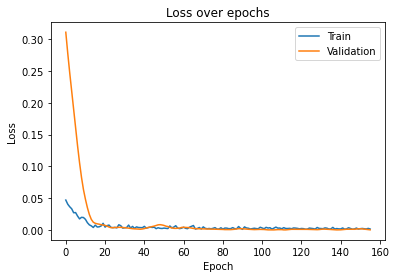

22 22 22


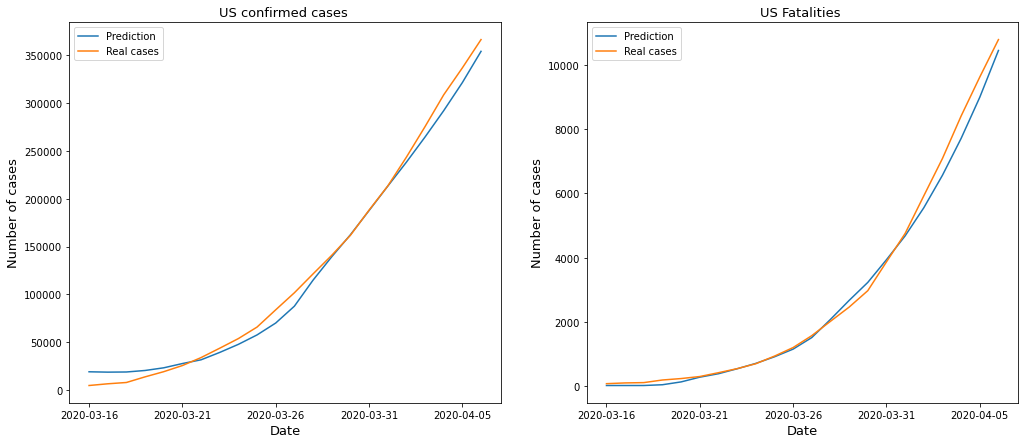

In [150]:
nfeatures = data.shape[1]
time_step = 6
# Data generator

model = aLSTM(time_step, nfeatures=nfeatures)
print('[Model] Training Started')
print('[Model] %s epochs, %s batch size' % (epochs, batch_size))

# model.load_weights(save_fname)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=50),
    ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True),
#     TensorBoard(log_dir='./logs')
]
history = model.fit(x=X_train,y=Y_train, 
                    validation_data=(X_val,Y_val),
                    validation_steps=1,
                    callbacks=callbacks,steps_per_epoch=1,epochs=epochs,verbose=1)
model.save(save_fname)
print('[Model] Training Completed. Model saved as %s' % save_fname)
printFigure(history)
# Performance in train data
Confirmed_train, Fatalities_train = plotTrainFigure(model, train_generator, data, sc2, time_step, country=country)

In [ ]:
# Confirmed_train, Fatalities_train = plotTrainFigure(model, train_generator, data, sc2, time_step, country=country)

In [151]:
for i in range(len(validation_gen)):
    print(i)
    testx, testy = validation_gen[i]

    pre = model.predict(testx)

    confirmed_pre = pre[0][0]
    confirmed_truth = testy[0][0]
    fatalities_pre = pre[0][1]
    fatalities_truth = testy[0][1]
    print(confirmed_pre,  confirmed_truth,  fatalities_pre, fatalities_truth)

0
0.92948985 1.0 1.0099335 1.0
